In [3]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from radiomics import featureextractor
from tqdm import tqdm
from IPython.display import clear_output
from itertools import product
import radiomics
import cv2 as cv

from utils import patient, dataset_INCan, extractor_settings, features_df

# Extraction trials

In [23]:
def transformation(im: sitk.Image, parameterMap_path:str, format='np', show=False):
    """apply transformation to an image

    Args:
        im (sitk.Image): image to be transformed
        parameterMap (sitk.ParameterMap): transformation settings
        format (str, optional): output format. Defaults to 'np'.

    Returns:
        np.array or sitk.Image: transformed image
    """
    transformixImageFilter = sitk.TransformixImageFilter()
    parameterMap = sitk.ReadParameterFile(str(parameterMap_path))
    transformixImageFilter.SetTransformParameterMap(parameterMap)
    transformixImageFilter.SetMovingImage(im)
    transformixImageFilter.Execute()
    im_result = transformixImageFilter.GetResultImage()
    clear_output(wait=show)
    if format=='sitk':
        return im_result
    elif format=='np':
        im_array = sitk.GetArrayFromImage(im_result)
        im_array = im_array.astype(np.uint16)
        return im_array
    else:
        raise ValueError('format must be "sitk" or "np"')
    

def points_in_circle(radius):
    """iterable that yields all possible combinations of x and y coordinates within cicle of fixed radius

    Args:
        radius (int): radius of circle

    Yields:
        set: set with combinations304
    """
    for x, y in product(range(int(radius) + 1), repeat=2):
        if x**2 + y**2 <= radius**2:
            yield from set(((x, y), (x, -y), (-x, y), (-x, -y),))

def translate_image(im:np.array, x_trans:int, y_trans:int):
    """translate image given x and y translation

    Args:
        im (np.array): image to be translated
        x_trans (int): x translation
        y_trans (int): y translation

    Returns:
        np.array: translated image
    """
    #get height and width
    height, width = im.shape[:2]
    #create translation matrix
    T = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
    #translate
    img_translation = cv.warpAffine(im, T, (width, height))

    return img_translation

Min and max of fixed: 11546, 14659
Min and max of moving: 11579, 14659
Min and max of substraction: -14648, 737


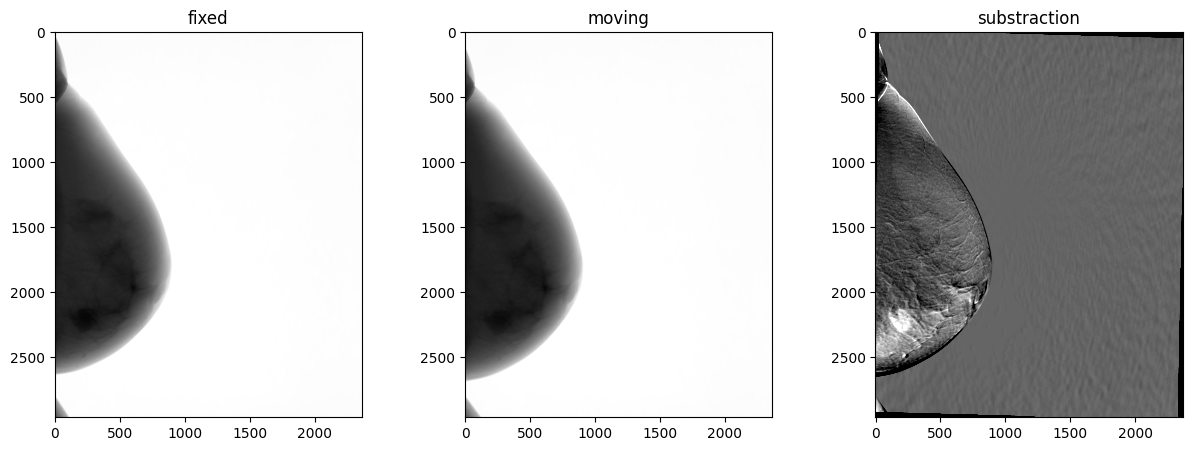

In [45]:
pat_num = '3'
pat = patient(pat_num=pat_num)
#define fixed and moving
fixedImage = pat.get_im(sequence='CMC', format = 'sitk')
movingImage = pat.get_im(sequence='SMC', format='sitk')

im_transformed = transformation(movingImage, repo_path / f'data/registration/transform_{pat_num}.txt', format='sitk')

fixed_array = sitk.GetArrayFromImage(fixedImage)
im_transformed_array = sitk.GetArrayFromImage(im_transformed)

im_moved_array = translate_image(im_transformed_array, 0, 0)
im_substraction = -(fixed_array.astype(np.int32) - im_moved_array.astype(np.int32)).astype(np.int16)

# show orignal images and registration
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(sitk.GetArrayFromImage(fixedImage), cmap='gray')
ax[0].set_title('fixed')
ax[1].imshow(sitk.GetArrayFromImage(movingImage), cmap='gray')
ax[1].set_title('moving')
ax[2].imshow(im_substraction, cmap='gray', vmin=-87, vmax=133)
ax[2].set_title('substraction')

print(f'Min and max of fixed: {sitk.GetArrayFromImage(fixedImage).min()}, {sitk.GetArrayFromImage(fixedImage).max()}')
print(f'Min and max of moving: {sitk.GetArrayFromImage(movingImage).min()}, {sitk.GetArrayFromImage(movingImage).max()}')
print(f'Min and max of substraction: {im_substraction.min()}, {im_substraction.max()}')

In [44]:
# save im_substraction
im_substraction_sitk = sitk.GetImageFromArray(im_substraction)
im_substraction_sitk.CopyInformation(fixedImage)
sitk.WriteImage(im_substraction_sitk, 'miau.tif')

In [24]:
# extraction settings
param_path = repo_path / 'data/param_files/Param_2D_sym.json' #path of parameter file
extractor = extractor_settings(param_path, show=False)
logger = radiomics.logging.getLogger('radiomics')
logger.setLevel(radiomics.logging.ERROR)

# other settings
dataset = dataset_INCan()
saving_dir = repo_path / 'data/budget/substractions'
saving_dir.mkdir(exist_ok=True)

#Get all point coordinates inside the circle
coord_list = list(points_in_circle(radius=2))

# loop 1
(x_trans, y_trans) = coord_list[0]
# loop 2
rad = 'L'
time = '1'

df_all = pd.DataFrame()
# loop 3
counter_pat = tqdm(dataset.pat_num, desc='pat_num')
for pat_num in counter_pat:
    #define fixed and moving
    pat = patient(pat_num=pat_num)
    fixedImage = pat.get_im(sequence='CMC', format = 'sitk')
    movingImage = pat.get_im(sequence='SMC', format='sitk')
    # transform
    im_transformed = transformation(movingImage, repo_path / f'data/registration/transform_{pat_num}.txt', format='sitk')
    # substract
    fixed_array = sitk.GetArrayFromImage(fixedImage)
    im_transformed_array = sitk.GetArrayFromImage(im_transformed)
    im_substraction = -(fixed_array.astype(np.int32) - im_transformed_array.astype(np.int32)).astype(np.int16)
    sitk_substraction = sitk.GetImageFromArray(im_substraction)
    sitk_substraction.CopyInformation(fixedImage)

    # extract features
    result = extractor.execute(sitk_substraction, pat.get_seg(rad=rad, time=time, format='sitk'))

    # get features and store in dataframe
    df = features_df(result, id_num=pat_num)

    # stack to df_all
    df_all = pd.concat([df_all, df])
# save
df_all.to_csv(saving_dir / f'x{x_trans}-y{y_trans}_{rad}_{time}.csv')

pat_num:  18%|█▊        | 6/33 [00:06<00:30,  1.13s/it]

ELASTIX version: 5.000
Command line options from ElastixBase:
-out      ./
-threads  unspecified, so all available threads are used
-def      unspecified, so no input points transformed
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed

Reading input image ...
  Reading input image took 0.000003 s
Calling all ReadFromFile()'s ...
  Calling all ReadFromFile()'s took 0.000044 s
Transforming points ...
  The command-line option "-def" is not used, so no points are transformed
  Transforming points done, it took 0.00s
Compute determinant of spatial Jacobian ...
  The command-line option "-jac" is not used, so no det(dT/dx) computed.
  Computing determinant of spatial Jacobian done, it took 0.00s
Compute spatial Jacobian (full matrix) ...
  The command-line option "-jacmat" is not used, so no dT/dx computed.
  Computing spatial Jacobian done, it took 0.00s
Resampling image and writing to disk ...


pat_num:  18%|█▊        | 6/33 [00:06<00:30,  1.14s/it]

  Resampling took 0.47s


SystemError: <built-in function TransformixImageFilter_Execute> returned a result with an exception set

# Understaing the results

We analize here the feature values extracted from the shifted SET images.

In [8]:
budget_dir = repo_path / 'data/budget/substractions'
budget_files = [budget_dir / file for file in os.listdir(budget_dir) if file.endswith('.csv')]

The budget is defined as the variation of the feature due to both ROI and registration uncertainty. As such it is the standard deviation of the feature value among the files. <br>
Because the values of the features are different between features, a coefficient of variation (CV) is computed as the ratio between the budget and the mean of the feature. <br>

# General case

In [9]:
# read each indpendent csv file and stack them in a single dataframe
budget_df = pd.concat([pd.read_csv(file) for file in budget_files], ignore_index=True) 
budget_mean = budget_df.groupby('pat_num').mean()
budget_std = budget_df.groupby('pat_num').std()
budget_cv = budget_std/budget_mean

In [7]:
# mean of cv as a single value
budget_cv_mean = budget_cv.mean().abs()
budget_cv_mean.to_csv(budget_dir.parent / 'budget_ROI_and_rad.csv')
# save also mean of means to unscale the data
budget_mean_mean = budget_mean.mean()
budget_mean_mean.to_csv(budget_dir.parent / 'budget_mean_mean.csv')

# actual budget for computation
budget = budget_mean_mean * budget_cv_mean
budget.to_csv(budget_dir.parent / 'budget_computations.csv')

## Individual case
Remember pandas uses the Unbiased estimation of standard deviation for std.

the vector mean is 0.512213842273835
the vector std is 0.12804833148421696
the vector cv is 0.2499899864396108


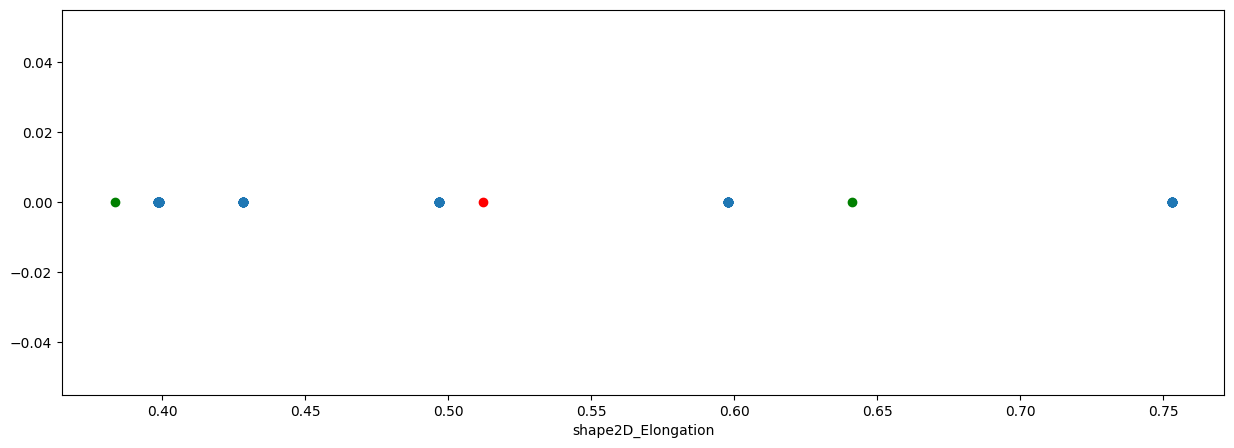

In [25]:
pat_num = 2
feature_name = 'shape2D_Elongation'

# read each indpendent csv file and stack them in a single dataframe
budget_df = pd.concat([pd.read_csv(file) for file in budget_files], ignore_index=True) 
# get dataframe with only pat_num 2
budget_df = budget_df[budget_df['pat_num']==pat_num]
# get mean of each column
budget_mean = budget_df.mean(axis=0).to_frame().T
budget_std = budget_df.std(axis=0).to_frame().T
budget_cv = budget_df.std(axis=0).to_frame().T / budget_df.mean(axis=0).to_frame().T
vector = budget_df[feature_name].to_numpy()

print(f'the vector mean is {vector.mean()}')
print(f'the vector std is {vector.std()}')
print(f'the vector cv is {vector.std()/vector.mean()}')

# plot vector as points in one line, meaning all points have same x value
plt.figure(figsize=(15,5))
plt.plot(vector, np.zeros_like(vector), 'o')
plt.xlabel(feature_name)
# show mean and std
plt.plot(budget_mean[feature_name], 0, 'o', color='red')
plt.plot(budget_mean[feature_name] + budget_std[feature_name], 0, 'o', color='green')
plt.plot(budget_mean[feature_name] - budget_std[feature_name], 0, 'o', color='green')